# CounterFactual Experiment

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import itertools
import warnings
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.utils import Bunch
from typing import cast
from CounterFactualModel import CounterFactualModel
from ConstraintParser import ConstraintParser
import CounterFactualVisualizer as CounterFactualVisualizer
importlib.reload(CounterFactualVisualizer)
from CounterFactualVisualizer import (plot_pca_with_counterfactual, plot_sample_and_counterfactual_heatmap, 
                                     plot_pca_loadings, plot_constraints, 
                                     plot_sample_and_counterfactual_comparison, plot_pairwise_with_counterfactual_df,
                                     plot_pca_with_counterfactuals, plot_explainer_summary)
from CounterFactualExplainer import CounterFactualExplainer

warnings.filterwarnings("ignore")

## Setup + Constants

In [3]:
CLASS_COLORS_LIST = ['purple', 'green', 'orange']
IRIS: Bunch = cast(Bunch, load_iris())
IRIS_FEATURES = IRIS.data
IRIS_LABELS = IRIS.target

TRAIN_FEATURES, TEST_FEATURES, TRAIN_LABELS, TEST_LABELS = train_test_split(IRIS_FEATURES, IRIS_LABELS, test_size=0.3, random_state=42)

MODEL = RandomForestClassifier(n_estimators=3, random_state=42)
MODEL.fit(TRAIN_FEATURES, TRAIN_LABELS)


ORIGINAL_SAMPLE = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
SAMPLE_DATAFRAME = pd.DataFrame([ORIGINAL_SAMPLE])  # Wrapping sample in a list to create a DataFrame

CONSTRAINT_PARSER = ConstraintParser("constraints/custom_l100_pv0.001_t2_dpg_metrics.txt")
CONSTRAINTS = CONSTRAINT_PARSER.read_constraints_from_file()

cf_dpg = CounterFactualModel(MODEL, CONSTRAINTS, verbose=True)  # Ensure you are using the correct constraints (nested_dict)
TARGET_CLASS = 0
ORIGINAL_SAMPLE_PREDICTED_CLASS = MODEL.predict(SAMPLE_DATAFRAME)

RULES = ['no_change', 'non_increasing', 'non_decreasing']
FEATURES_NAMES = list(ORIGINAL_SAMPLE.keys())
RULES_COMBINATIONS = list(itertools.product(RULES, repeat=len(FEATURES_NAMES)))


NUMBER_OF_COMBINATIONS_TO_TEST = 6
NUMBER_OF_REPLICATIONS_PER_COMBINATION = 2
INITIAL_POPULATION_SIZE = 20
MAX_GENERATIONS = 50


## Constraints Extracted from DPG

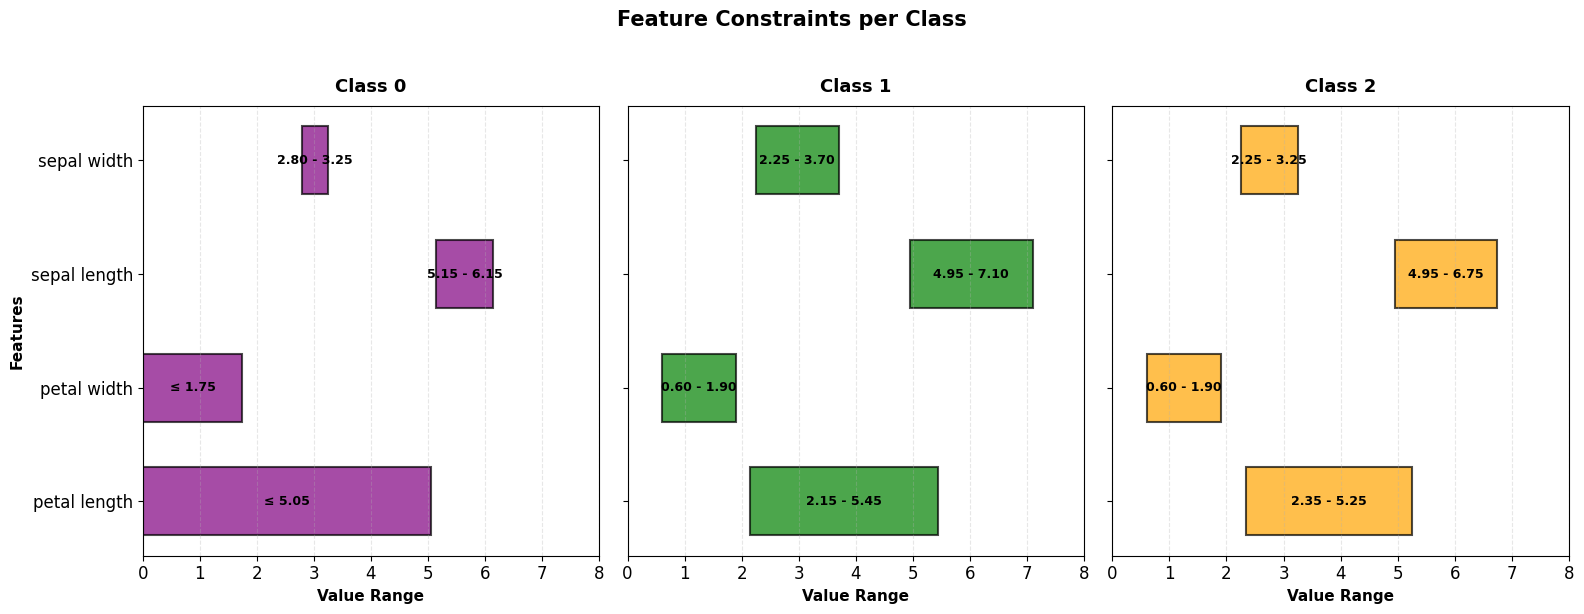

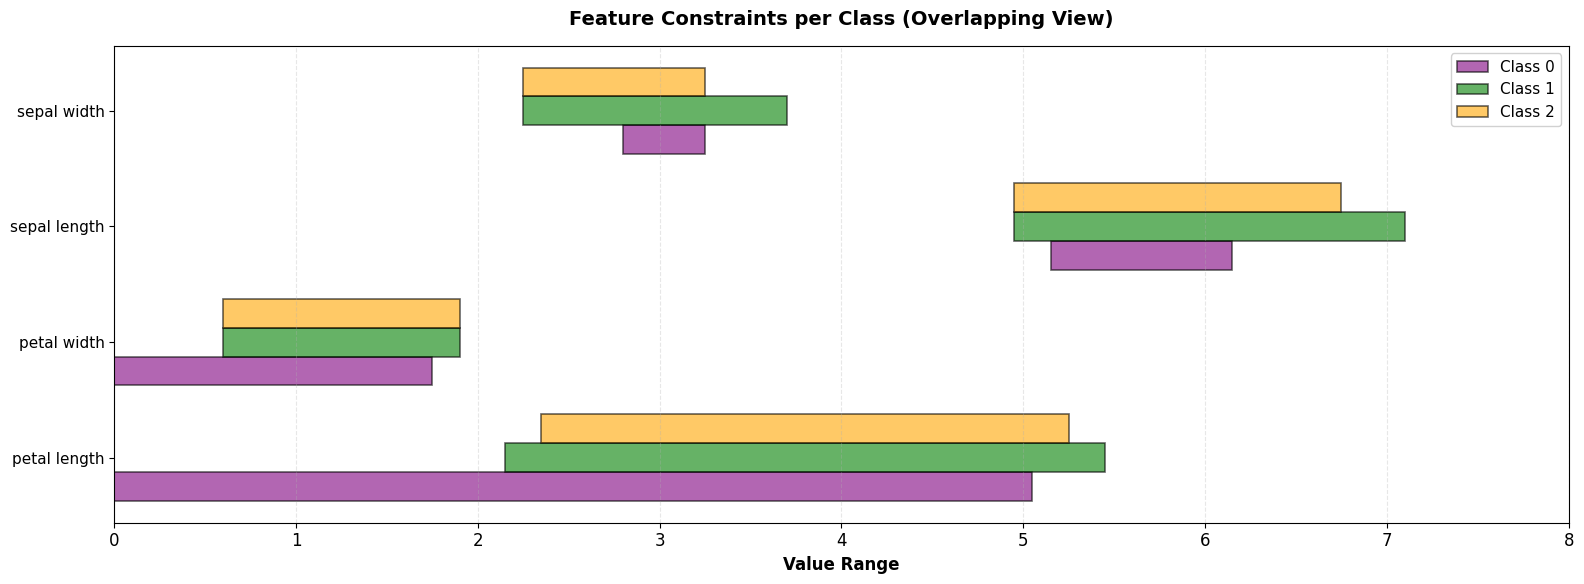

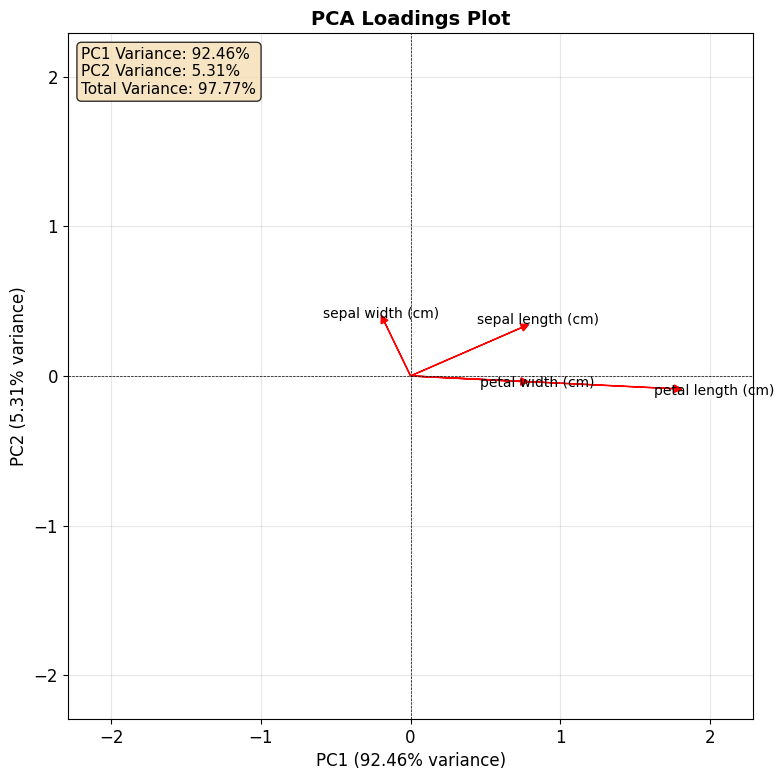

In [4]:

plot_constraints(CONSTRAINTS, overlapping=False, class_colors_list=CLASS_COLORS_LIST)
plot_constraints(CONSTRAINTS, overlapping=True, class_colors_list=CLASS_COLORS_LIST)
plot_pca_loadings(IRIS_FEATURES, IRIS.feature_names)

## Generate Counterfactuals with All Rule Combinations

In [5]:
counterfactuals_df_combinations = []
visualizations = []

for combination in RULES_COMBINATIONS[:NUMBER_OF_COMBINATIONS_TO_TEST]:
    dict_non_actionable = dict(zip(FEATURES_NAMES, combination))
    counterfactuals_df_replications = []
    combination_viz = {
        'pairwise': None,
        'pca': None,
        'replication': []
    }
    
    for replication in range(NUMBER_OF_REPLICATIONS_PER_COMBINATION):
        print(f"\nCombination: {dict_non_actionable}, Replication: {replication + 1}/{NUMBER_OF_REPLICATIONS_PER_COMBINATION}")
        
        cf_dpg = CounterFactualModel(MODEL, CONSTRAINTS)
        cf_dpg.dict_non_actionable = dict_non_actionable

        counterfactual = cf_dpg.generate_counterfactual(ORIGINAL_SAMPLE, TARGET_CLASS, INITIAL_POPULATION_SIZE, MAX_GENERATIONS)
        if (counterfactual == None):
            print("No counterfactual found for combination:", dict_non_actionable)
            continue
        print("Counterfactual found for combination:", dict_non_actionable)
        

        replication_viz = [
            plot_sample_and_counterfactual_heatmap(ORIGINAL_SAMPLE, ORIGINAL_SAMPLE_PREDICTED_CLASS, counterfactual,  MODEL.predict(pd.DataFrame([counterfactual])),  dict_non_actionable),
            plot_sample_and_counterfactual_comparison(MODEL, ORIGINAL_SAMPLE, SAMPLE_DATAFRAME, counterfactual, CLASS_COLORS_LIST),
            cf_dpg.plot_fitness()
        ]
        combination_viz['replication'].append(replication_viz)

        EXPLAINER = CounterFactualExplainer(cf_dpg, ORIGINAL_SAMPLE, counterfactual, TARGET_CLASS)
        plot_explainer_summary(EXPLAINER, ORIGINAL_SAMPLE, counterfactual)


        # Prepare data for DataFrame
        cf_data = counterfactual.copy()
        cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})
        cf_data['Replication'] = replication + 1
        counterfactuals_df_replications.append(cf_data)
    
    # Convert replications to DataFrame and plot for this specific combination
    if counterfactuals_df_replications:
        counterfactuals_df_replications = pd.DataFrame(counterfactuals_df_replications)
        
        # Extract only the feature columns for plotting
        feature_cols = [col for col in counterfactuals_df_replications.columns if not col.startswith('Rule_') and col != 'Replication']
        cf_features_only = counterfactuals_df_replications[feature_cols]
        
        combination_viz['pairwise'] = plot_pairwise_with_counterfactual_df(MODEL, IRIS_FEATURES, IRIS_LABELS, ORIGINAL_SAMPLE, cf_features_only)
        combination_viz['pca'] = plot_pca_with_counterfactuals(MODEL, pd.DataFrame(IRIS_FEATURES), IRIS_LABELS, ORIGINAL_SAMPLE, cf_features_only)
        
        # Add all replications to the overall combinations list
        counterfactuals_df_combinations.extend(counterfactuals_df_replications.to_dict('records'))
    
    visualizations.append(combination_viz)


# Convert all combinations to DataFrame
counterfactuals_df_combinations = pd.DataFrame(counterfactuals_df_combinations)


Combination: {'petal width (cm)': 'no_change', 'petal length (cm)': 'no_change', 'sepal length (cm)': 'no_change', 'sepal width (cm)': 'no_change'}, Replication: 1/2
No counterfactual found for combination: {'petal width (cm)': 'no_change', 'petal length (cm)': 'no_change', 'sepal length (cm)': 'no_change', 'sepal width (cm)': 'no_change'}

Combination: {'petal width (cm)': 'no_change', 'petal length (cm)': 'no_change', 'sepal length (cm)': 'no_change', 'sepal width (cm)': 'no_change'}, Replication: 2/2
No counterfactual found for combination: {'petal width (cm)': 'no_change', 'petal length (cm)': 'no_change', 'sepal length (cm)': 'no_change', 'sepal width (cm)': 'no_change'}

Combination: {'petal width (cm)': 'no_change', 'petal length (cm)': 'no_change', 'sepal length (cm)': 'no_change', 'sepal width (cm)': 'non_increasing'}, Replication: 1/2
No counterfactual found for combination: {'petal width (cm)': 'no_change', 'petal length (cm)': 'no_change', 'sepal length (cm)': 'no_change',


Combination 1

Combination 2

Combination 3

Combination 4

Pairwise Plot:


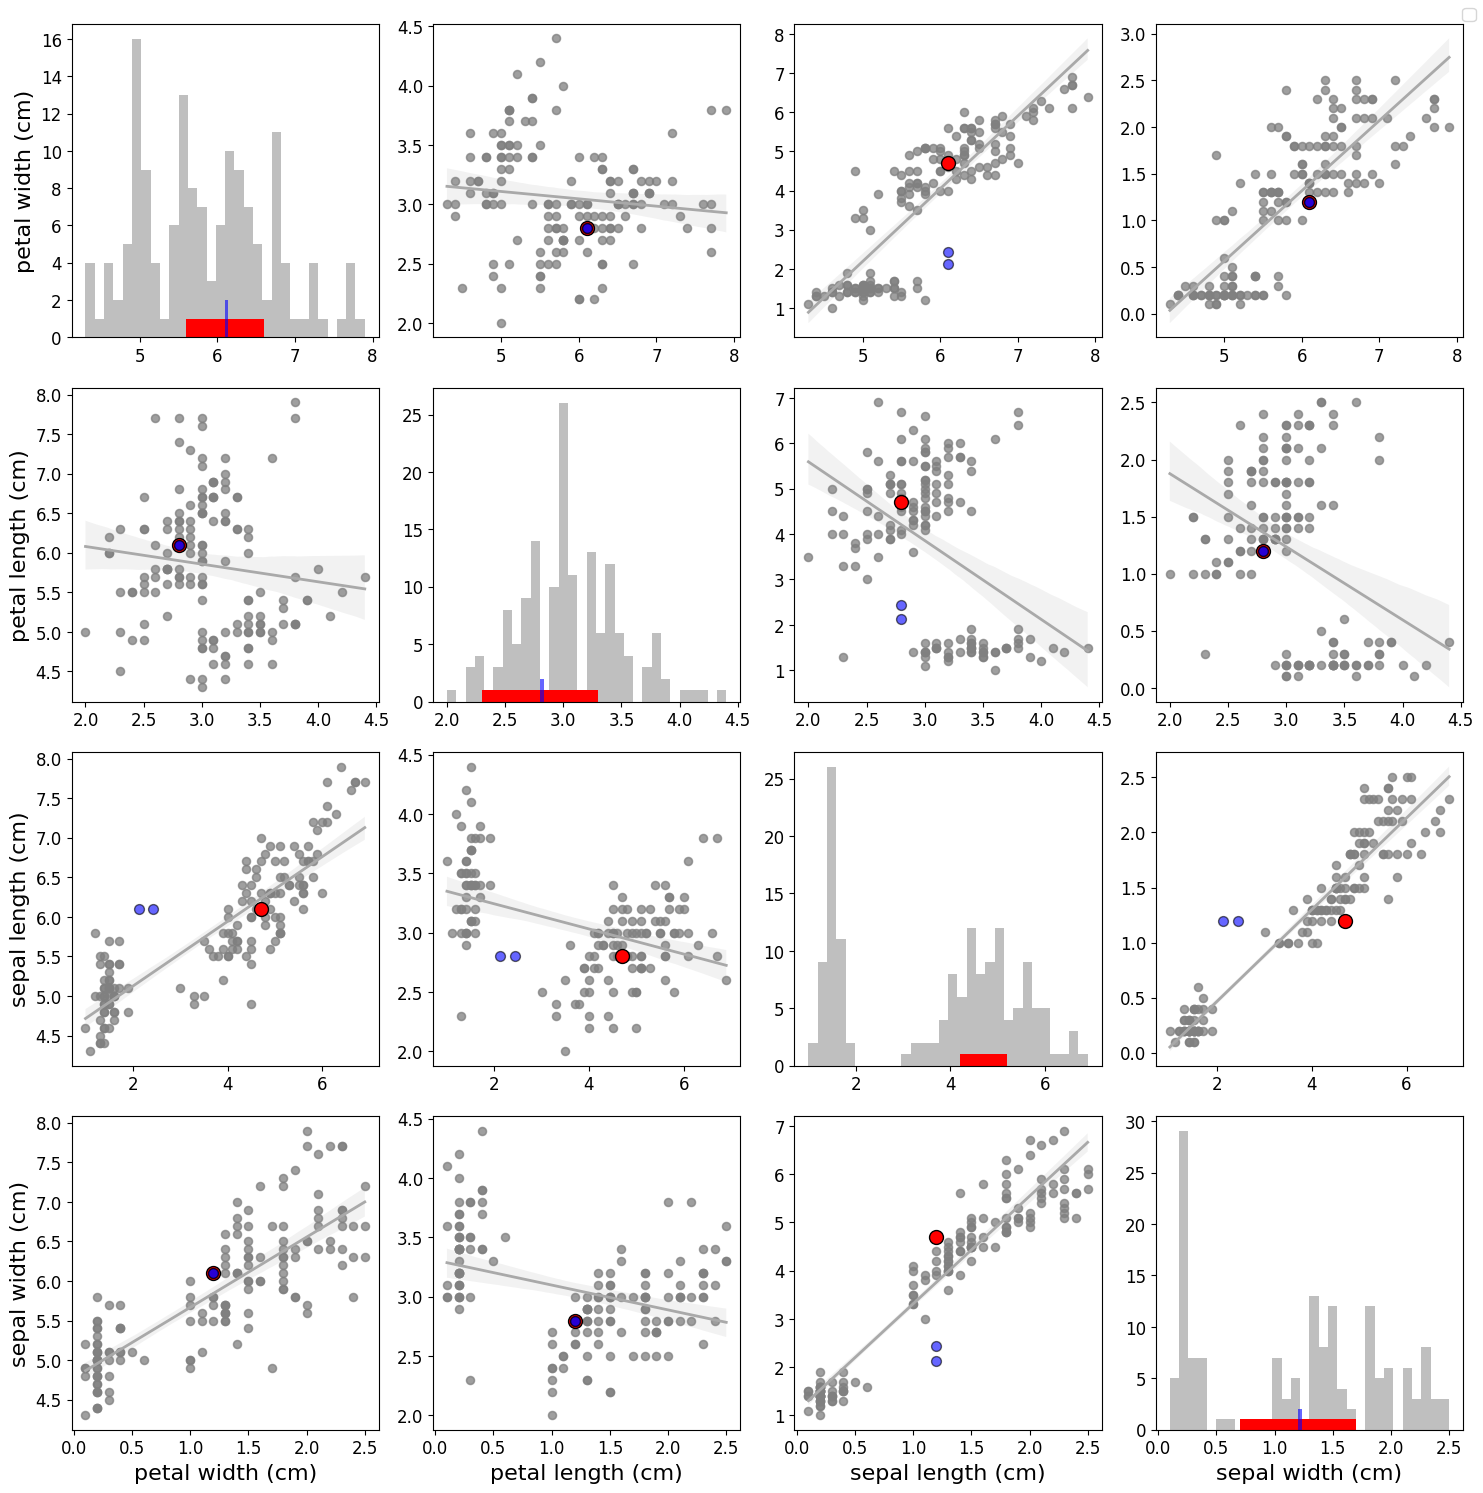


PCA Plot:


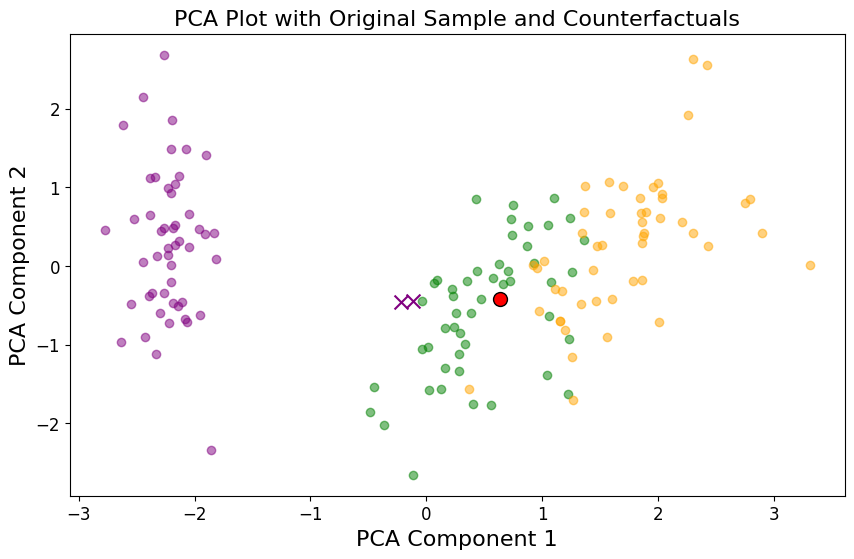


Replication 1:


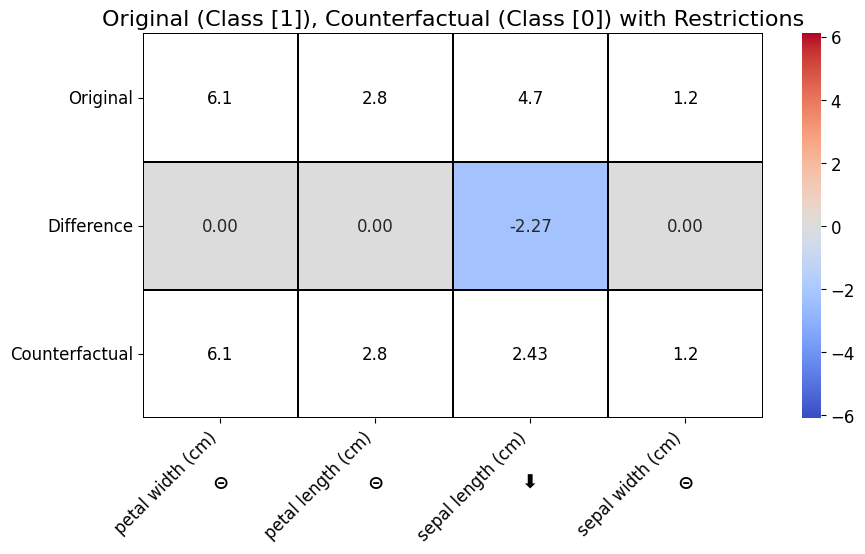

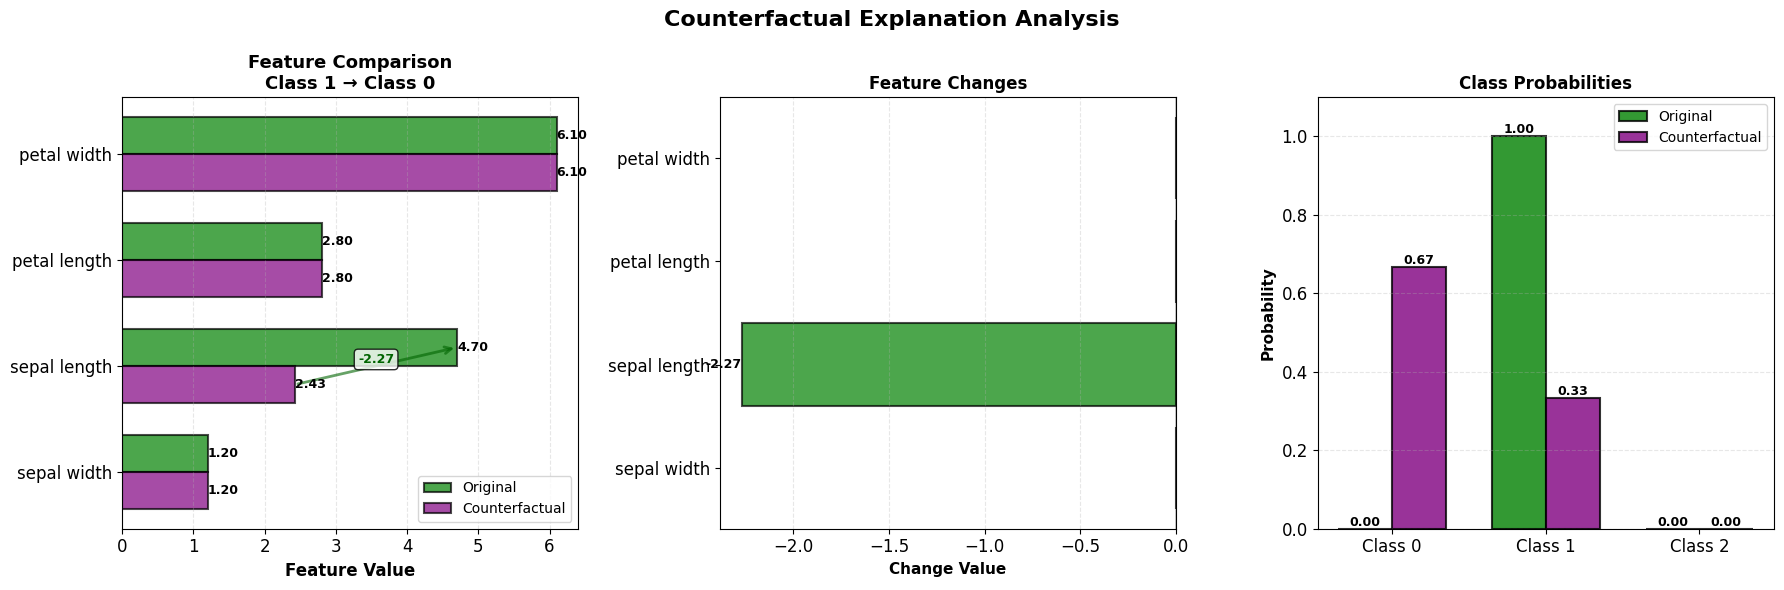

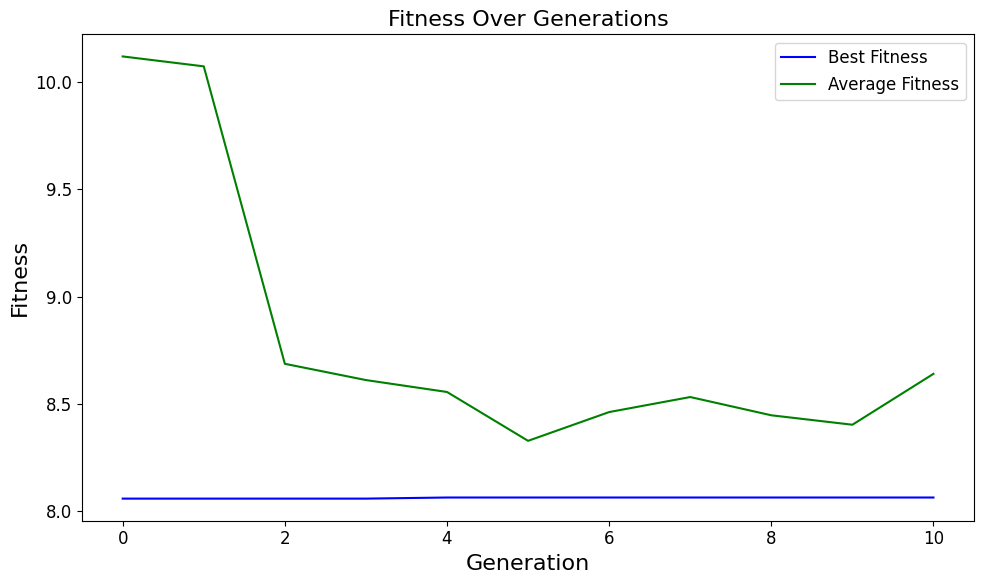


Replication 2:


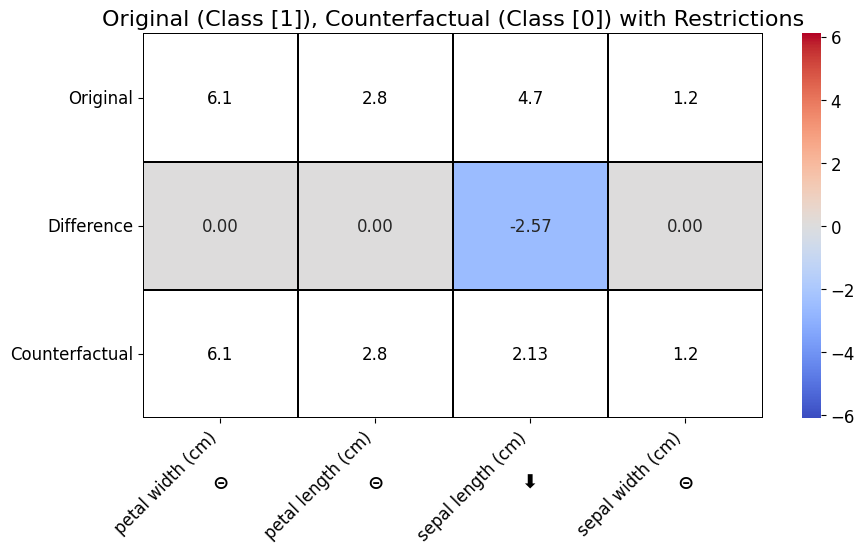

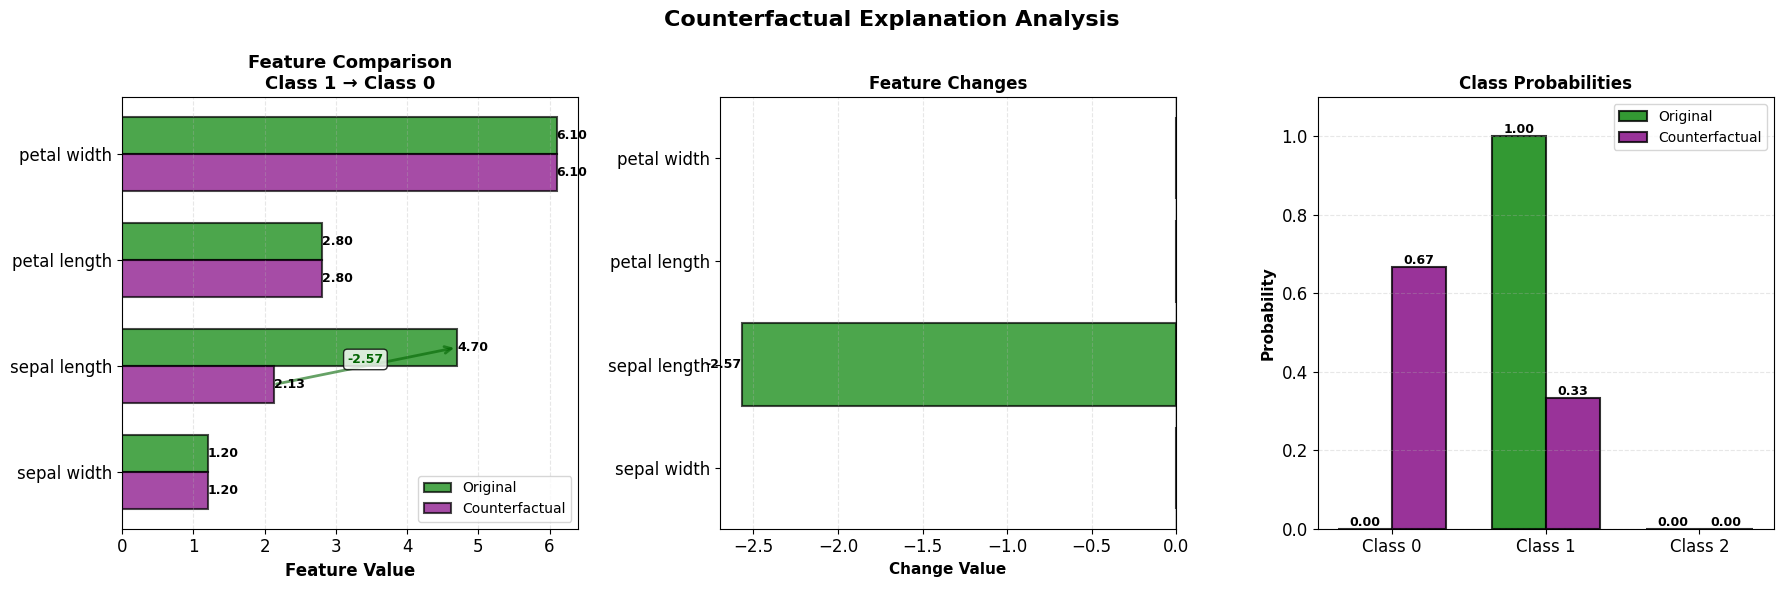

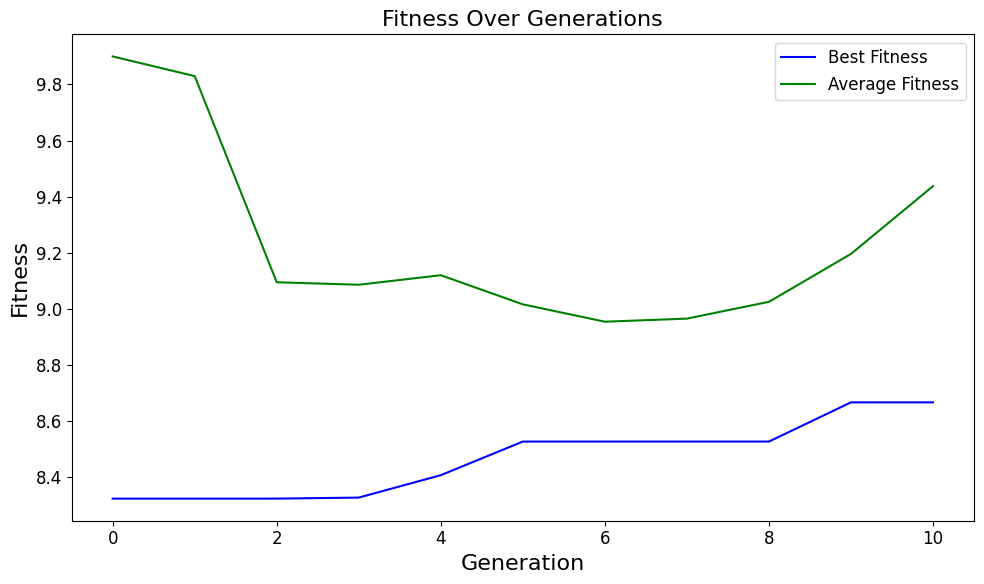


Combination 5

Pairwise Plot:


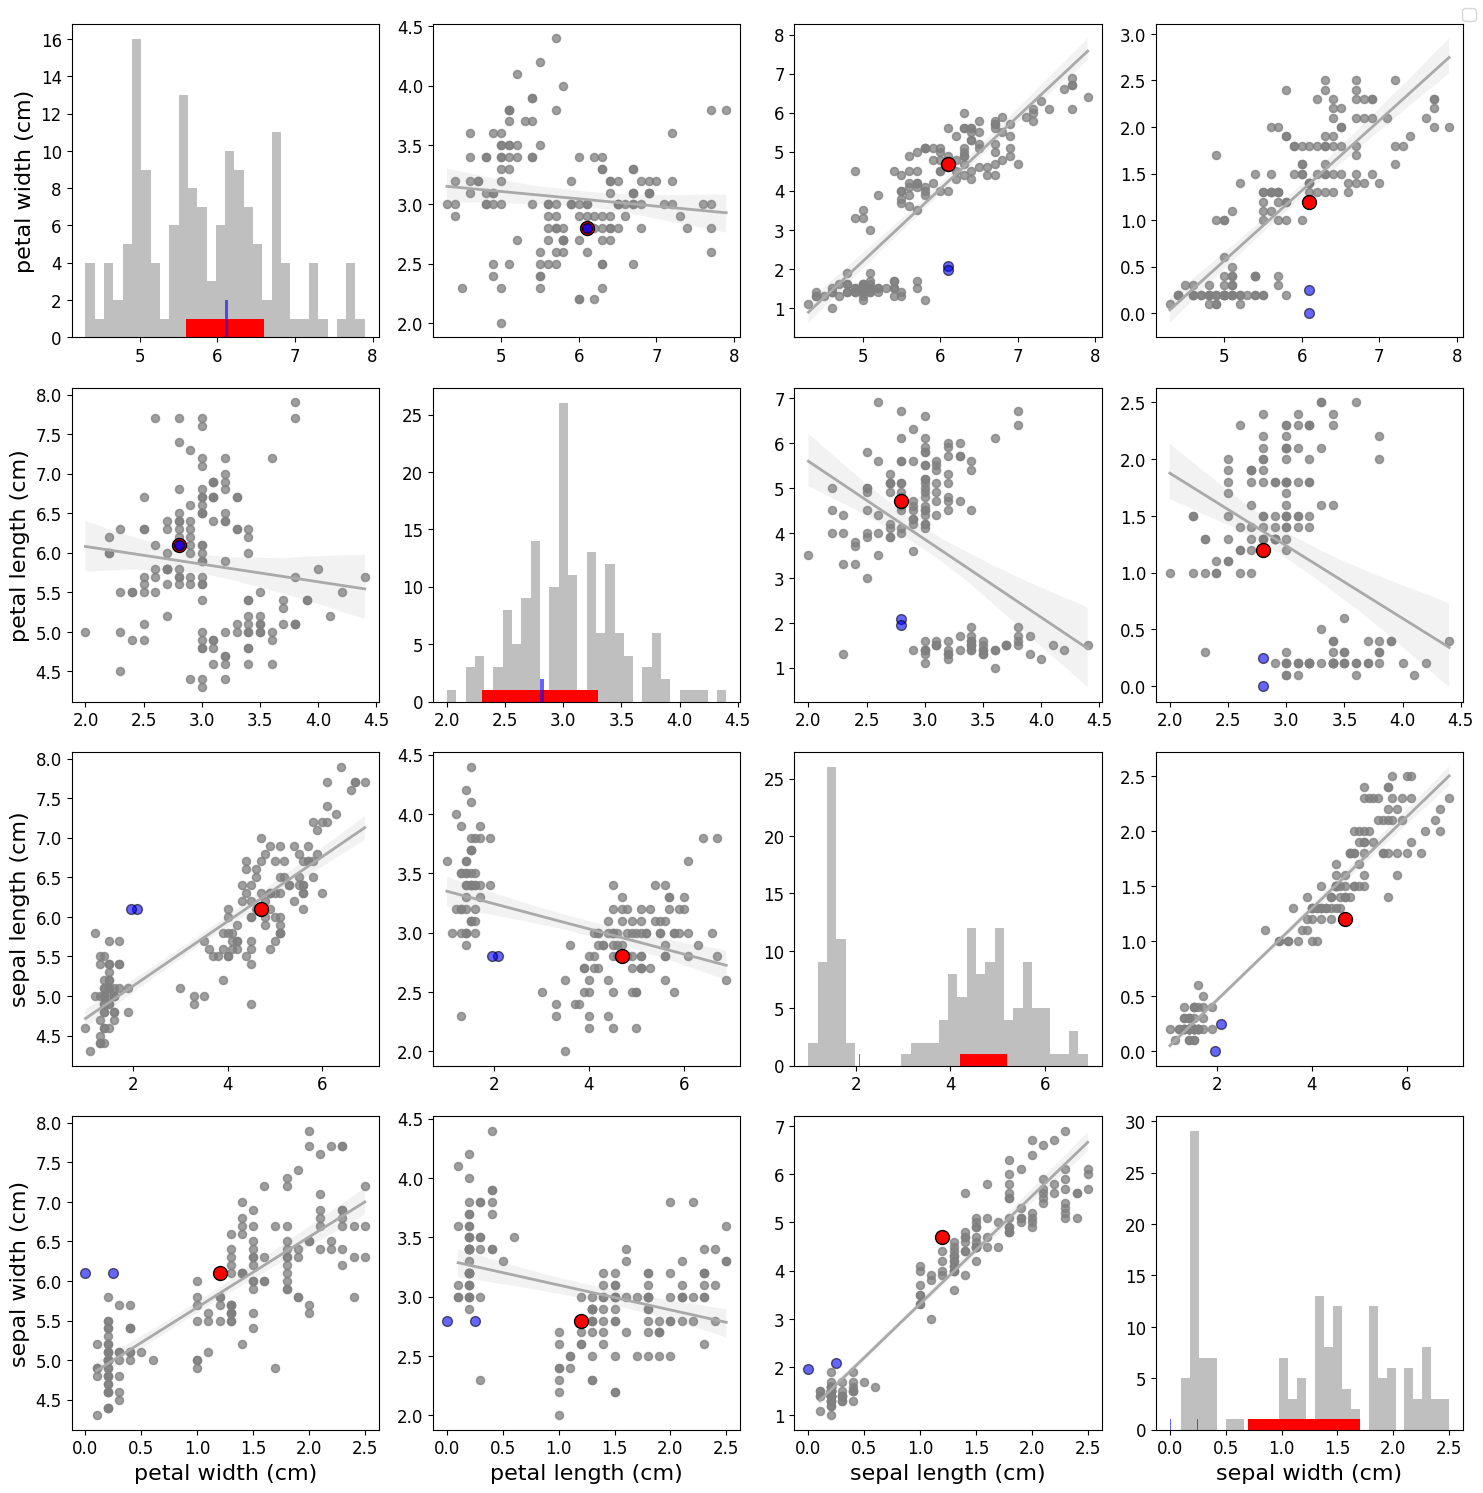


PCA Plot:


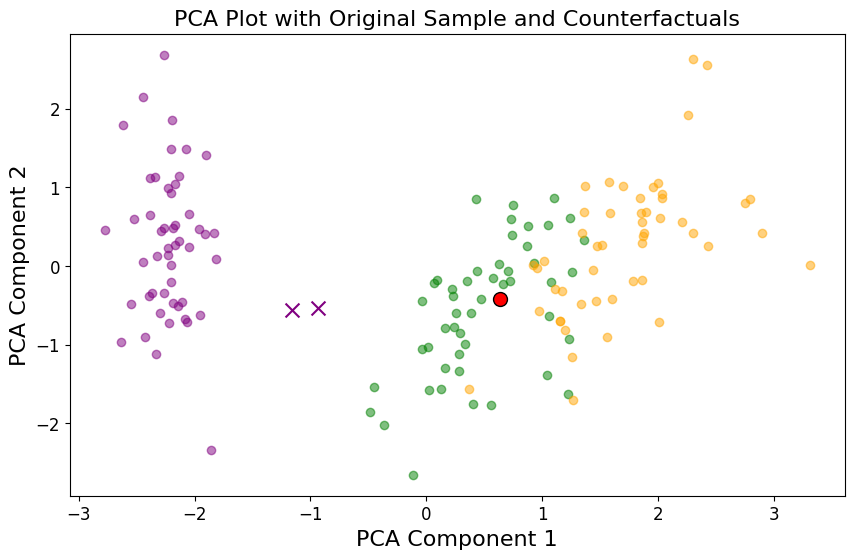


Replication 1:


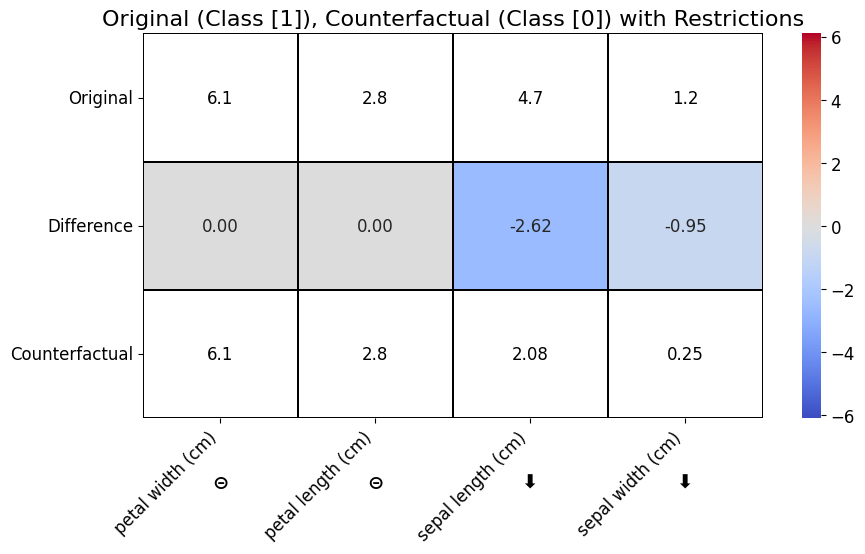

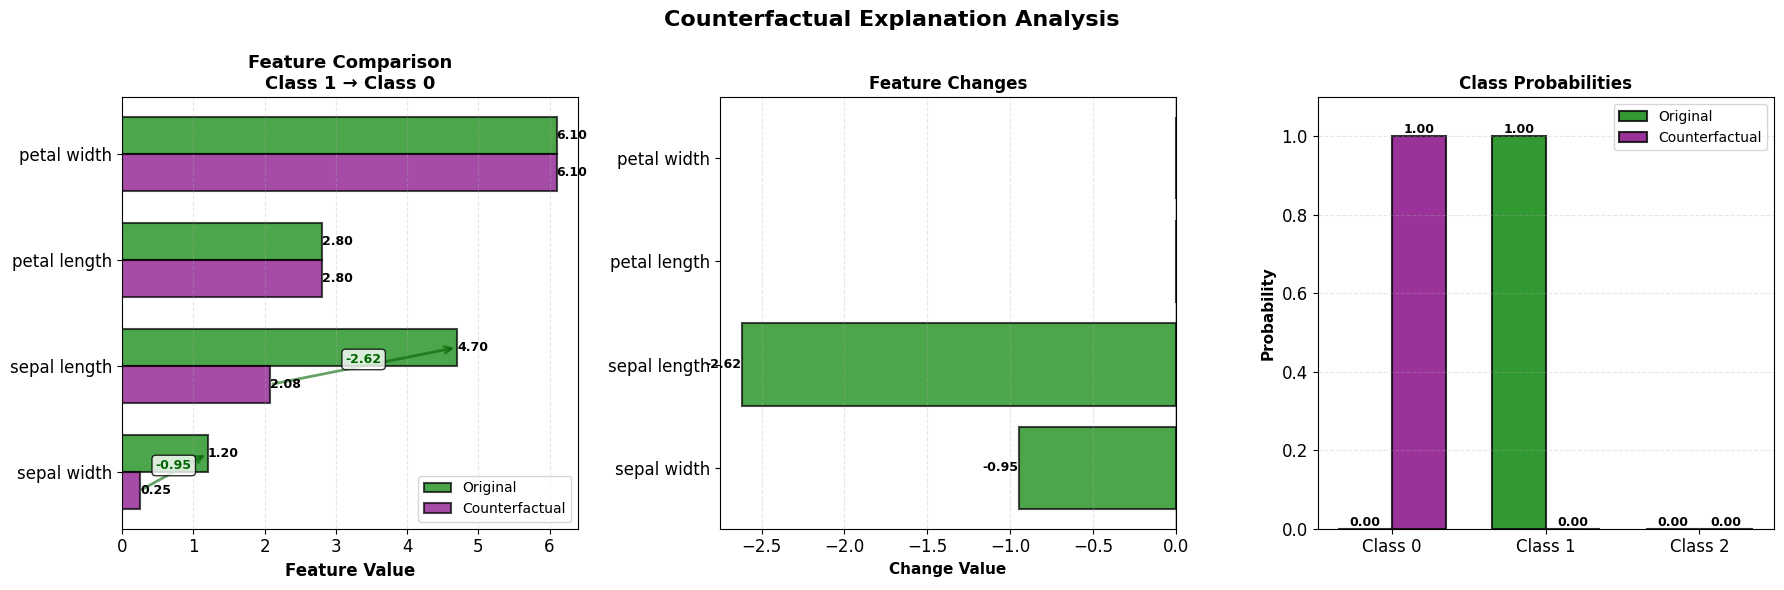

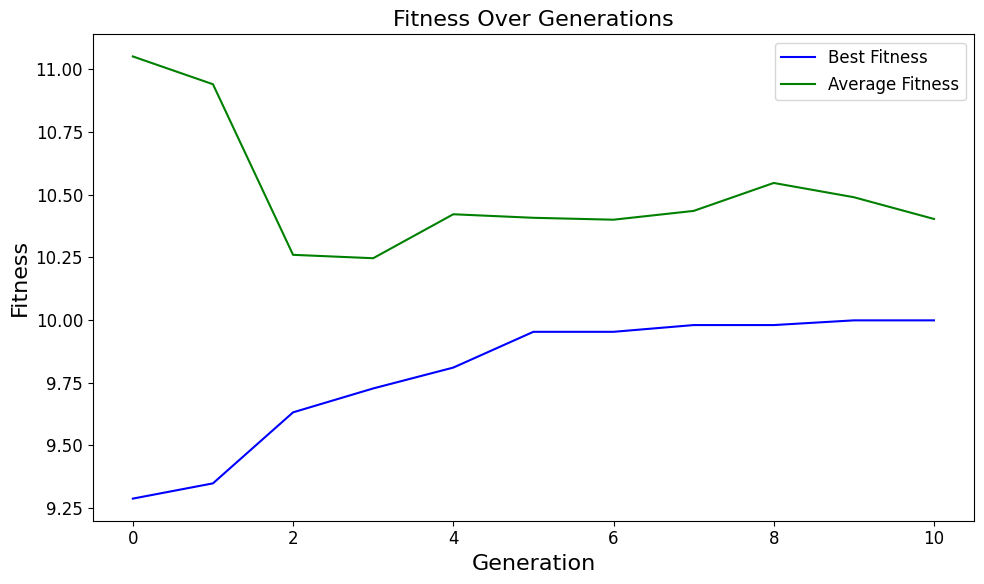


Replication 2:


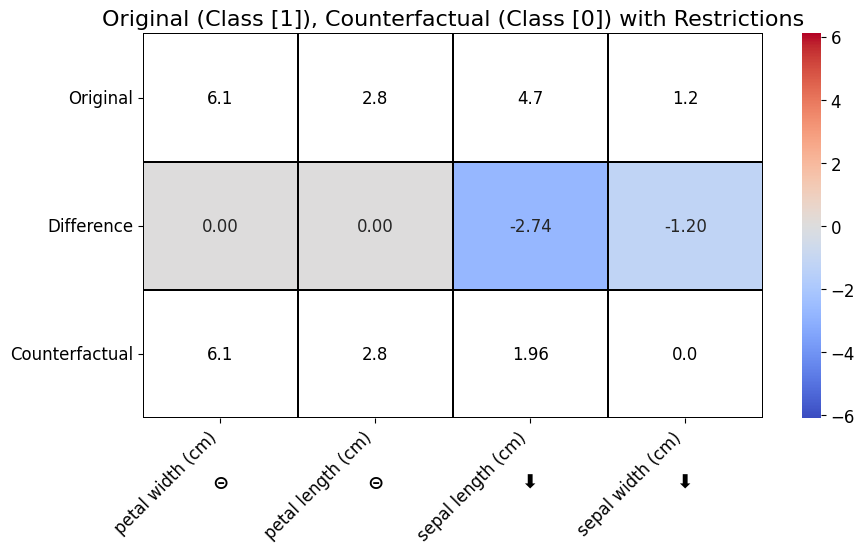

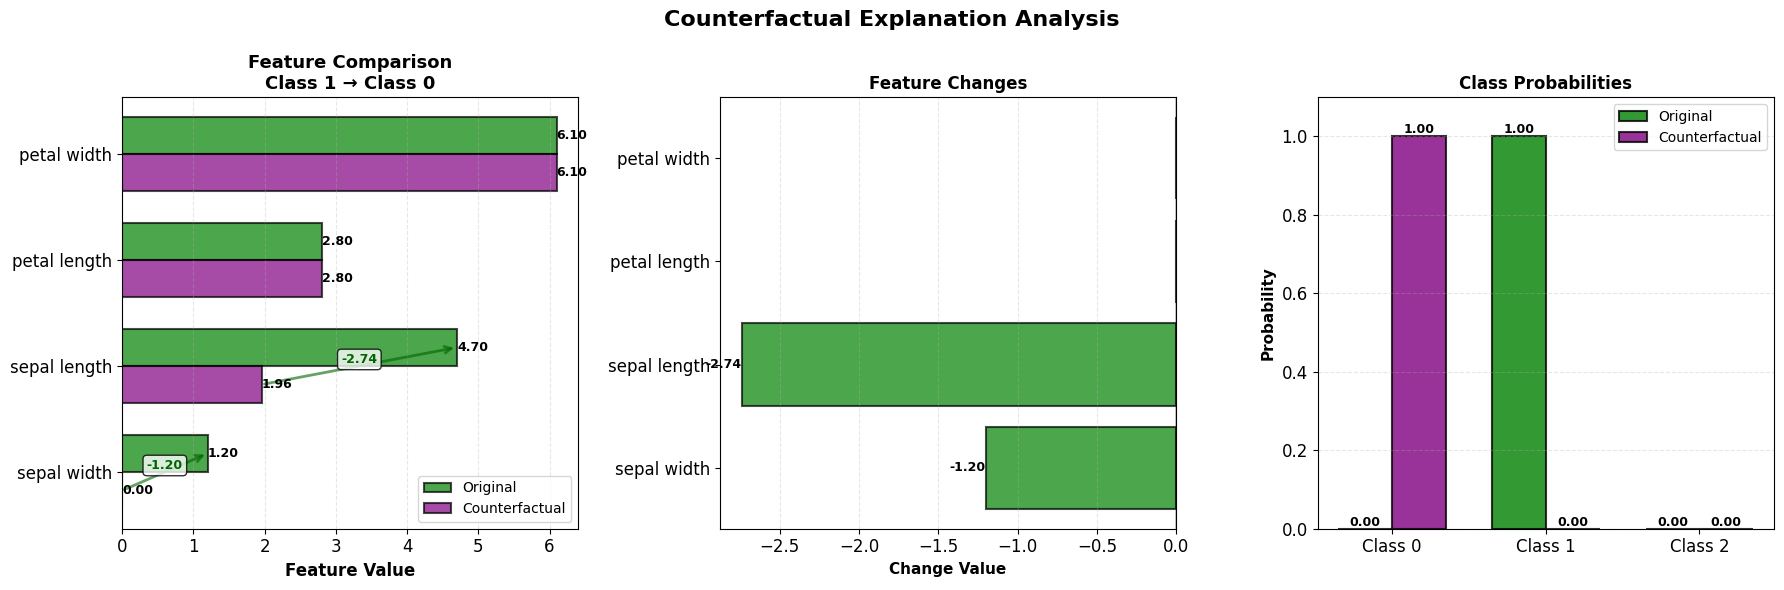

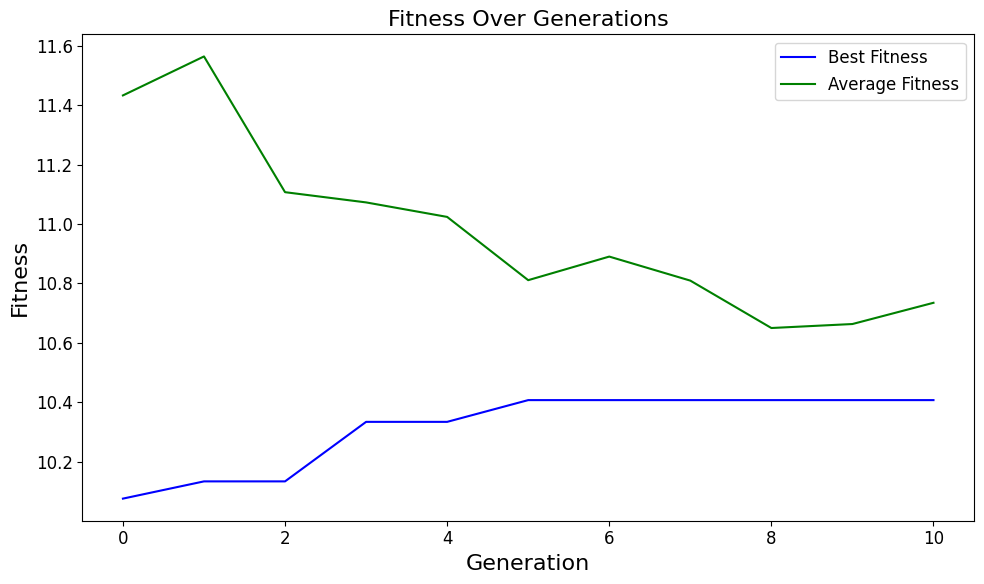


Combination 6


In [6]:
# Display all visualizations from the collected list
for idx, combination_viz in enumerate(visualizations):
    print(f"\n{'='*60}")
    print(f"Combination {idx + 1}")
    print(f"{'='*60}")
    
    # Display pairwise plot
    if combination_viz['pairwise'] is not None:
        print("\nPairwise Plot:")
        display(combination_viz['pairwise'])
    
    # Display PCA plot
    if combination_viz['pca'] is not None:
        print("\nPCA Plot:")
        display(combination_viz['pca'])
    
    # Display replication visualizations
    for rep_idx, replication_viz in enumerate(combination_viz['replication']):
        print(f"\nReplication {rep_idx + 1}:")
        for viz_idx, viz in enumerate(replication_viz):
            display(viz)